# Mandelbrot on all accelerators

This notebook demonstrates a single mathematical problem—computing the Mandelbrot set—on a variety of Python accelerators.

The Mandelbrot problem was chosen because it is both good and bad for vectorization:

   * the value of each pixel can be computed independently, but
   * the calculation of each pixel requires a different number of iterations—some pixels converge more quickly than others.

Thus, we're faced with the choice of unnecessarily recomputing already-converged pixels or complex bookkeeping to avoid recomputation. Since computation is generally faster than memory transfers, unnecessary recomputation wins. Pure array-oriented interfaces that perform multiple passes over the data, creating intermediates (allocating memory and copying), are visibly worse than single-pass computation, with or without recomputation.

It is a good illustration of the benefits and pitfalls of array-oriented performance. NumPy is better than Python `for` loops because the iteration is compiled over data that are dense in memory, but the last order of magnitude of performance comes from fusing all the steps to compute a pixel into a new array-oriented kernel, or by simply compiling the loop. This pattern is evident on both CPUs and GPUs.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

## Python "for" loops: imperative

The first test uses ordinary Python `for` loops, though the data are in NumPy arrays.

To compute a Mandelbrot set, we make a grid representing the complex plane (`c`) and another grid that counts the number of iterations before the value of

$$z \to z^2 + c$$

seems to diverge ($|z| > 2$). The number of iterations as a function of position in the complex plane is the familiar Mandelbrot image.

Python is _very_ slow, owing to a lot of familiar reasons: numbers are all boxed objects, randomly distributed in memory ("pointer chasing"), they are untyped, requiring type-checks at every step in the loop, everything goes through a virtual machine that has a garbage collector, etc.

We only run this Python implementation on a grid of 200×300 pixels, which is 100× fewer than all the other tests.

In [2]:
def run_python(height, width):
    y, x = np.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = np.full(c.shape, 20, dtype=np.int32)
    for h in range(height):
        for w in range(width):                  # for each pixel (h, w)...
            z = c[h, w]
            for i in range(20):                 # iterate at most 20 times
                z = z**2 + c[h, w]              # applying z → z² + c
                if abs(z) > 2:                  # if it diverges (|z| > 2)
                    fractal[h, w] = i           # color the plane with the iteration number
                    break                       # we're done, no need to keep iterating
    return fractal

Notice the pixelation in the image: this is a low resolution run.

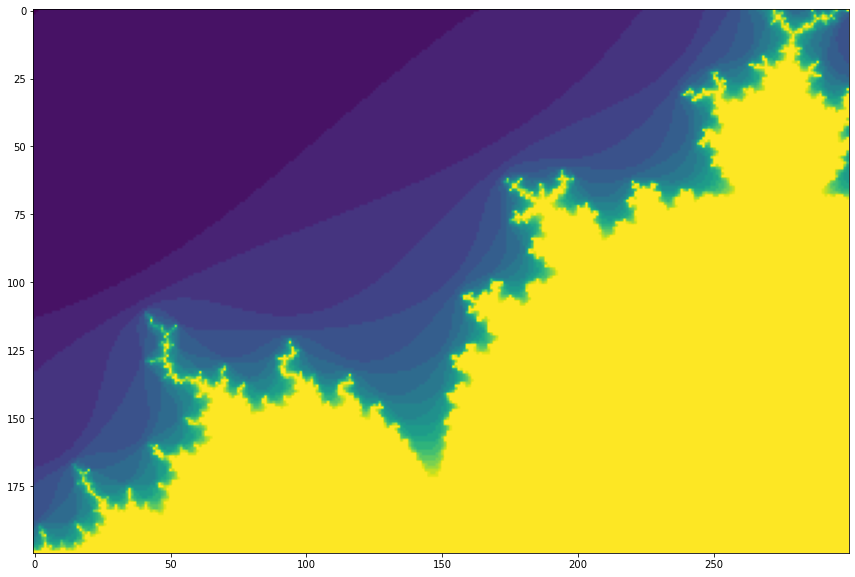

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(run_python(200, 300));   # running on 100× fewer pixels than all other tests (low resolution)

In [4]:
%%timeit -o
run_python(200, 300)               # running on 100× fewer pixels than all other tests

249 ms ± 1.38 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 249 ms ± 1.38 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [5]:
result_python = _

## NumPy: array-oriented

NumPy is the first step for most numerical work in Python. Many Python users interact with NumPy through Pandas, which is considered a staple for Pythonic data analysis. Almost all data-crunching libraries in Python have array-oriented interfaces and interface with NumPy arrays as a first-class data type.

The array-oriented interface is user-visible, and in some cases considered a _syntactic_ improvement over explicit `for` loops.

Regardless of how you feel about it as a convenient syntax, the array-oriented interface requires some changes to the Mandelbrot calculation:

   * `z = z**2 + c` has no array subscripts (yay!)
   * we can't `break` from the loop up to `20` when divergence is identified (boo!)
   * so we have to do some additional bookkeeping to determine which pixels are just starting to diverge in a given iteration step (double-boo!)

Algorithms that must "iterate until converged" (like this one) are generally bad for array-oriented interfaces because vectorization naturally wants to apply the same instructions on multiple data (SIMD), and stopping after convergence is different for different data. That's why the Mandelbrot calculation is a good example.

Also, `np.absolute(z) > 2` is noticeably worse than `z.real**2 + z.imag**2 > 4` because of the extra calculation of a square root. We only didn't see this in the Python code because iterating through Python was by itself more expensive than calculating square roots. In fact, `abs(z) > 2` is faster in Python because it involves fewer virtual machine operations.

In [6]:
def run_numpy(height, width):
    y, x = np.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = np.full(c.shape, 20, dtype=np.int32)
    z = c
    for i in range(20):
        z = z**2 + c                                 # applying z → z² + c
        diverged = z.real**2 + z.imag**2 > 4         # |z| > 2 is "divergence"
        diverging_now = diverged & (fractal == 20)   # some are already done
        fractal[diverging_now] = i                   # just set the new ones
        z[diverged] = 2                              # clamp diverged at 2
    return fractal

Notice the lack of pixelation in the image: this, like all the ones that follow, is a high resolution run.

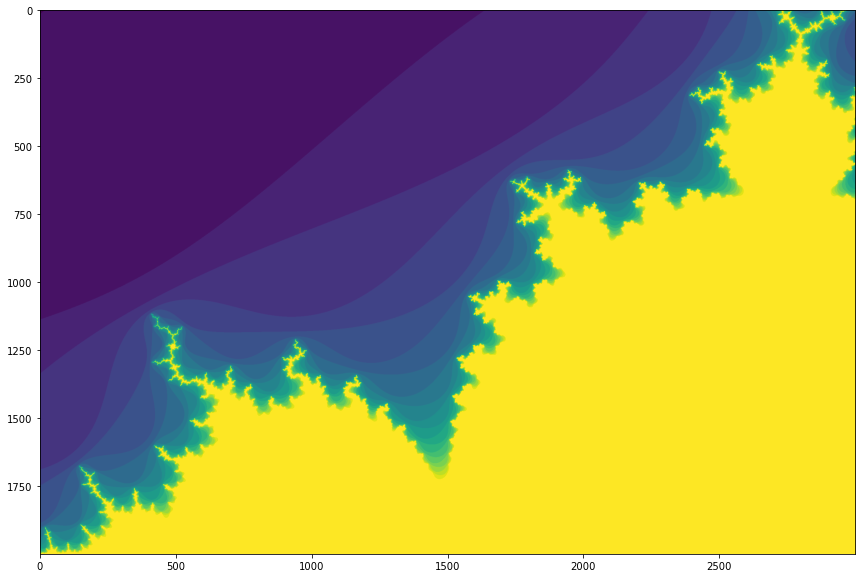

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plt.imshow(run_numpy(2000, 3000));

In [8]:
%%timeit -o
run_numpy(2000, 3000)

934 ms ± 8.69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 934 ms ± 8.69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [9]:
result_numpy = _

## pybind11: imperative in C++

The traditional way to avoid all performance limitations is to rewrite the Python algorithm in C++. That's what most professional libraries do. However, it introduces a packaging and distribution problem because compilation environments aren't the same on all systems, a problem generally solved by distributed precompiled wheels in pip or conda.

Here, we assume that this notebook is running on a system that has a working C++ (11) compiler.

The C++ code below is a transliteration of the Python code above. It uses pybind11 to wrap the `run` function in a Python extension module.

In [10]:
%%writefile run_pybind11.cpp
#include <complex>
#include <pybind11/pybind11.h>
#include <pybind11/numpy.h>

namespace py = pybind11;

void run(
    int height,
    int width,
    py::array_t<std::complex<double>> np_c,
    py::array_t<int> np_fractal
) {
    std::complex<double>* c = static_cast<std::complex<double>*>(np_c.request().ptr);

    int* fractal = static_cast<int*>(np_fractal.request().ptr);
    for (int h = 0;  h < height;  h++) {
        for (int w = 0;  w < width;  w++) {
            std::complex<double> ci = c[h + height*w];
            std::complex<double> z = ci;
            for (int i = 0;  i < 20;  i++) {
                z = z * z + ci;
                if (z.real()*z.real() + z.imag()*z.imag() > 4) {
                    fractal[h + height*w] = i;
                    break;
                }
            }
        }
    }
}

PYBIND11_MODULE(run_pybind11, m) {
    m.def("run", &run, "the inner loop");
}

Writing run_pybind11.cpp


The `pybind11` header-only library must be installed. That, and a `python -m pybind11 --includes` command to generate compiler arguments, are provided by the `pybind11` package on PyPI.

In [11]:
!pip install pybind11

  Using cached pybind11-2.9.2-py2.py3-none-any.whl (213 kB)


This compilation command assumes that you have either `python-config` or `python3-config` to generate an appropriate `--extension-suffix`.

The `-O3` and `-ffast-math` flags make a noticeable difference.

In [12]:
%%bash

export PYTHON_CONFIG=`which python-config python3-config | head -n1`

c++ -Wall -shared -std=c++11 -fPIC -O3 -ffast-math `python -m pybind11 --includes` run_pybind11.cpp -o run_pybind11`$PYTHON_CONFIG --extension-suffix`

The arrays must be owned by Python (NumPy arrays), so they must be created on the Python side and passed into the compiled function.

It's probably possible to create Python-owned arrays with pybind11, but I didn't bother for this test.

In [13]:
import run_pybind11

def run_c_plus_plus(height, width):
    y, x = np.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = np.full(c.shape, 20, dtype=np.int32)
    run_pybind11.run(height, width, c, fractal)
    return fractal

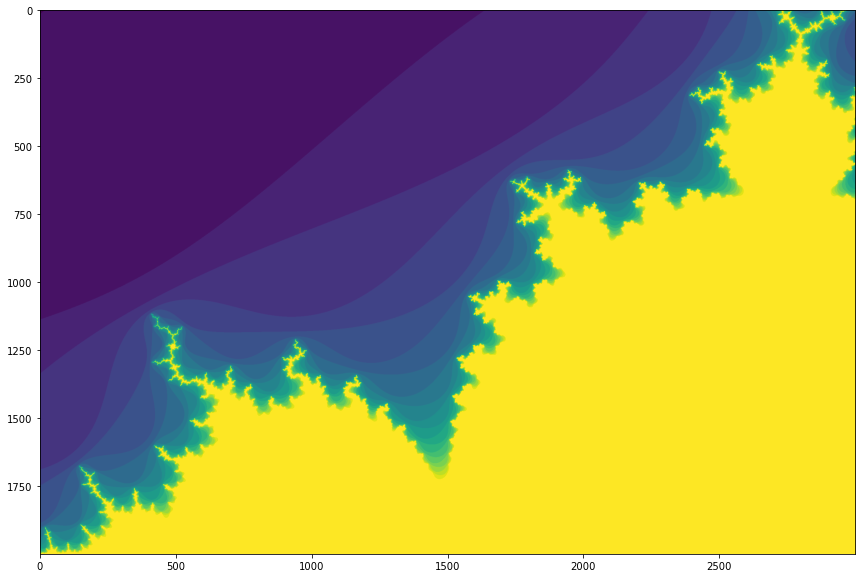

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(run_c_plus_plus(2000, 3000));

In [15]:
%%timeit -o
run_c_plus_plus(2000, 3000)

133 ms ± 1.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 133 ms ± 1.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [16]:
result_c_plus_plus = _

## Cython: imperative in a C++/Python hybrid

Another classic way to avoid performance issues in Python is to write the code using Cython, a hybrid language between C++ and Python.

It has the advantage that you can start with pure Python code and gradually speed it up by replacing Python-like statements with C++-like statements. In fact, Jupyter helps with this by letting you repeatedly run Cython code in a cell to hunt for bottlenecks. Passing a `-a` argument to `%%cython` shows a highlighted version of the code, in which more Python-like statements are more yellow. You can then focus on optimizing the hotspots and let the code that's only run once or a few times be Pythonic.

Note: I spent a lot of time on this one, finding incremental improvements with decorators like `@cython.boundscheck` and `@cython.wraparound`. The biggest surprise came more than 3 years after [the initial work](https://github.com/jpivarski-talks/python-numpy-mini-course/blob/master/6-compilers.ipynb) on this function: replacing `z**2` with `z * z` accounted for the last factor of 30×, which finally brought this implementation in line with the pure C++ implementation. Cython must be using a complex-number library with a bad `z**2` implementation, probably based on `pow` and not realizing that `2` is a compile-time constant.

(That line was _not_ yellow!)

In [17]:
%load_ext Cython

In [18]:
%%cython --cplus -c-O3 -c-ffast-math -c-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION
import cython
import numpy as np
cimport numpy as np

@cython.boundscheck(False) # <--- turn off bounds-checking
@cython.wraparound(False)  # <--- turn off negative index wrapping (e.g. -1 for last element)
def run_cython(int height, int width):
    y, x = np.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = np.zeros(c.shape, dtype=np.int32) + 20
    cdef np.ndarray[np.complex128_t, ndim=2, mode="c"] c_array = c
    cdef np.ndarray[np.int32_t,      ndim=2, mode="c"] fractal_array = fractal
    cdef np.complex128_t z
    for h in range(height):
        for w in range(width):
            z = c_array[h, w]
            for i in range(20):
                z = z * z + c_array[h, w]              # <--- z**2 → z * z is a 30× speedup
                if z.real**2 + z.imag**2 > 4:
                    fractal_array[h, w] = i
                    break
    return fractal

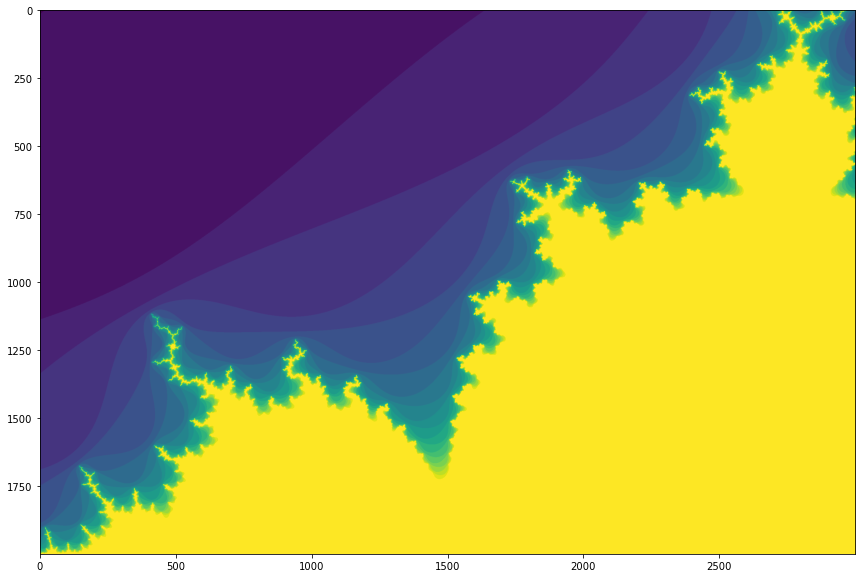

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(run_cython(2000, 3000));

In [20]:
%%timeit -o
run_cython(2000, 3000)

127 ms ± 892 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 127 ms ± 892 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [21]:
result_cython = _

## Numba: imperative in a compiled subset of Python

Whereas both pybind11 and Cython require a working C++ compiler (Cython hides it better, but the C++ compilation is still an external process), Numba is a JIT compiler that includes all compilation machinery (LLVM) in its package dependencies. Thus, you can `pip install numba` on a system without any compiler at all and Numba will compile your code for you.

Moreover, the code that Numba compiles is a strict subset of the Python language, not C++ and not a hybrid language. It is a _subset_ of Python because Python, as a language, was not designed for statically typed compilation. (PyPy is JIT-compiled but not statically typed, and therefore doesn't come close to Numba's performance.) A list of [supported Python language features](https://numba.pydata.org/numba-doc/dev/reference/pysupported.html) and [supported NumPy library features](https://numba.pydata.org/numba-doc/dev/reference/numpysupported.html) are maintained by the Numba developers, and data types from libraries unknown to Numba are not supported.

Compiling a function with `@nb.njit` ("n" for no-Python mode) reveals unsupported features in your function as error messages. You have to be willing to start small and build up your function gradually (like hunting for yellow lines with Cython), to be sure to only include supported features. But when you do, it reads like pure Python code and runs as fast as any compiled code.

This particular function is the same as the original Python function with one exception: `abs(z) > 2` → `z.real**2 + z.imag**2 > 4`.

In [22]:
import numba as nb

def run_numba(height, width):
    y, x = np.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    return numba_inner_loop(height, width, x, y)

@nb.njit(fastmath=True)                         # <--- like -ffast-math in the C++ compiler
def numba_inner_loop(height, width, x, y):
    c = x + y*1j
    fractal = np.full(c.shape, 20, dtype=np.int32)
    for h in range(height):
        for w in range(width):
            z = c[h, w]
            for i in range(20):
                z = z**2 + c[h, w]
                if z.real**2 + z.imag**2 > 4:   # <--- only difference from pure Python
                    fractal[h, w] = i
                    break
    return fractal

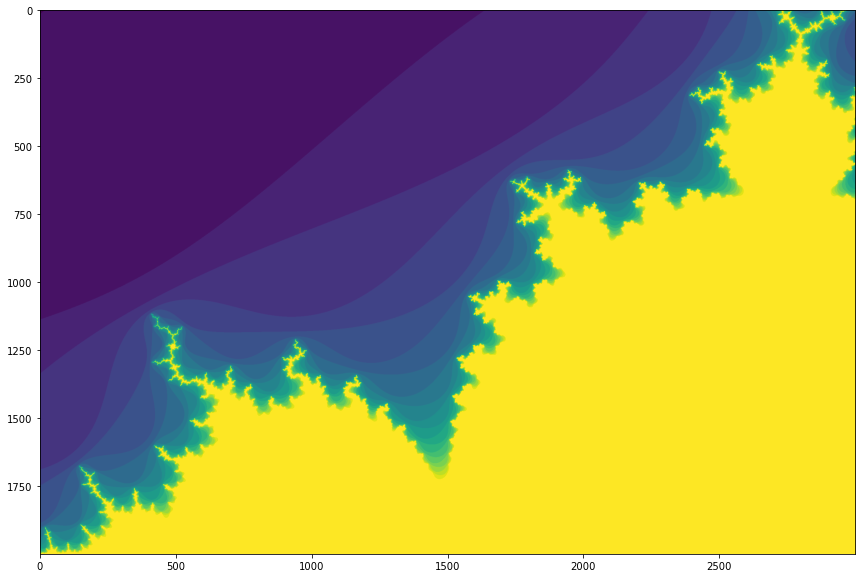

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plt.imshow(run_numba(2000, 3000));

In [24]:
%%timeit -o
run_numba(2000, 3000)

117 ms ± 1.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 117 ms ± 1.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [25]:
result_numba = _

## Numba vectorize: imperative per pixel, array-oriented in the large

Switching from pure Python to Numba is generally easier than switching from NumPy to Numba because Numba operates best on imperative code (`for` loops), not array-oriented code.

Some of NumPy's array-oriented features are not supported by Numba, but maybe more importantly, an array-oriented style that creates many or large intermediate arrays can't be faster when compiled. This is because it has already gained the advantage over pure Python by putting loops in compiled code, but it can't go the rest of the way by fusing operations into a single pass over all the data without allocating and copying data into intermediate arrays.

However, we can get the best of both by fusing operations over local data, a single pixel in the Mandelbrot calculation, into a function that can be used in an array-oriented way. This has exactly the same performance as the fully imperative implementation, but it is packaged in a way that could be used in Pandas, for instance.

In [26]:
@nb.vectorize(fastmath=True)
def fractal_ufunc(ci):
    z = ci
    for i in range(20):
        z = z**2 + ci
        if z.real**2 + z.imag**2 > 4:
            return i
    return 20

def run_numba_custom_ufunc(height, width):
    y, x = np.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    return fractal_ufunc(c.astype(np.complex64))

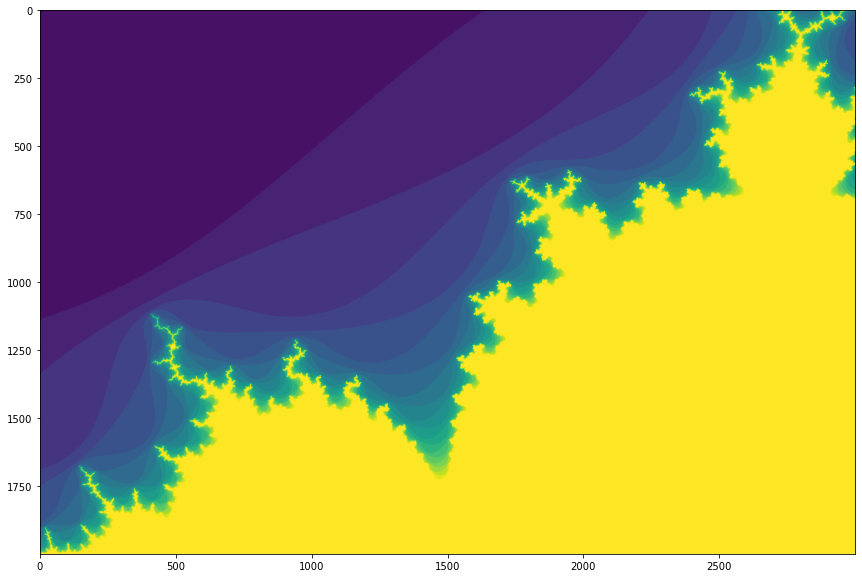

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plt.imshow(run_numba_custom_ufunc(2000, 3000));

In [28]:
%%timeit -o
run_numba_custom_ufunc(2000, 3000)

121 ms ± 1.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 121 ms ± 1.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [29]:
result_numba_custom_ufunc = _

## CuPy: array-oriented on a GPU

Now we move to different hardware, from CPUs to GPUs. GPUs can be much faster than CPUs, but they can _only_ be used in a vectorized way.

I distinguish between "array-oriented" and "vectorized" as follows:

   * **Array-oriented:** a user interface in which the basic data types are arrays and each operation is performed on whole arrays. Without a compiler that can analyze a whole program and fuse operations on the same data, each operation is a separate pass over the data, creating (allocating and copying into) intermediate arrays for the partial results. This can be a convenient interface because it lets you examine intermediate results as distributions and it beats pure Python for performance, but not single-pass computations without intermediates.
   * **Vectorized:** a hardware feature in which each machine code instruction is executed on multiple data values at the same time. CPUs have this feature in a small way (small vectors on SSE and AVX registers) and GPUs have this feature in a large way (warps of 32 or 64 bound threads).

An array-oriented interface lends itself to vectorized hardware because both involve single instructions acting on multiple data (SIMD). In NumPy, for instance, the "single instruction" is a NumPy function call that acts on every element of an array. Oddly enough, CUDA, the most popular framework for programming GPUs, presents an imperative/non-array-oriented interface to vectorized hardware. Users of CUDA have to keep in mind that `if` statements and `for` loops over variable-length lists have performance penalties.

The CuPy library implements NumPy's interface entirely on a GPU, allowing NumPy users to switch to GPUs with minimal changes to their code. For instance, the number of bytes per floating point number is more important than it is on CPUs.

Just as Numba lets you accelerate some pure Python code as-is, CuPy lets you accelerate some NumPy code as-is.

In [30]:
import cupy as cp

def run_cupy(height, width):
    y, x = cp.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = (x + y*1j).astype(np.complex64)                    # <--- only change from NumPy: 32-bit floats (complex64)
    fractal = cp.full(c.shape, 20, dtype=np.int32)
    z = c
    for i in range(20):
        z = z**2 + c
        diverged = z.real**2 + z.imag**2 > 4
        diverging_now = diverged & (fractal == 20)
        fractal[diverging_now] = i
        z[diverged] = 2
    return fractal.get()                                   # <--- and this: need to explicitly copy back from GPU

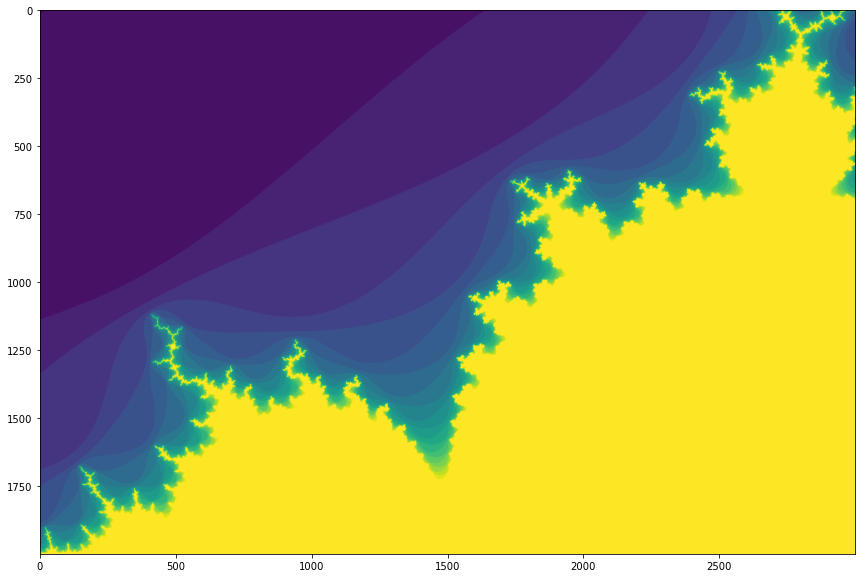

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(run_cupy(2000, 3000));

In [32]:
%%timeit -o
run_cupy(2000, 3000)

53.8 ms ± 128 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 53.8 ms ± 128 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [33]:
result_cupy = _

## CuPy with a custom kernel: imperative per pixel, array-oriented in the large

For exactly the same reason that Numba is faster than NumPy, it's faster to fuse all of the operations on local data (one pixel) with JIT-compilation. CuPy comes with a CUDA JIT-compiler to let you write arbitrary CUDA.

Although CUDA looks like imperative C++, the loop up to `20` is deceptive: if one CUDA thread `break`s out of the loop earlier than another in the same CUDA warp, that CUDA thread has to idle while the other threads finish up. If it were a "thread" in the CPU sense, it would move on to the next datum in the dataset. Experienced CUDA programmers expect this and work around it.

For this algorithm, however, it's unavoidable: "iterate until converged" is not friendly toward array-oriented programming.

In [34]:
cupy_custom_kernel = cp.RawKernel("""
#include <cupy/complex.cuh>

extern "C" __global__
void cupy_custom_kernel(int height, int width, int* fractal) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    complex<float> j(0.0, 1.0);
    complex<float> z, c;
    z = c = complex<float>(-1.5 + y*1.0/(height + 1)) - j + complex<float>(x*1.5)*j/complex<float>(width + 1);

    fractal[y + x*width] = 20;
    for (int i = 0;  i < 20;  i++) {
        z = z * z + c;
        if (z.real()*z.real() + z.imag()*z.imag() > 4) {
            fractal[y + x*width] = i;
            break;
        }
    }
}
""", "cupy_custom_kernel")

def run_cupy_custom_kernel(height, width):
    fractal = cp.empty((height, width), dtype=np.int32)
    griddim = (math.ceil(height / 32), math.ceil(width / 32))
    blockdim = (32, 32)
    cupy_custom_kernel(griddim, blockdim, (height, width, fractal))
    return fractal.get()

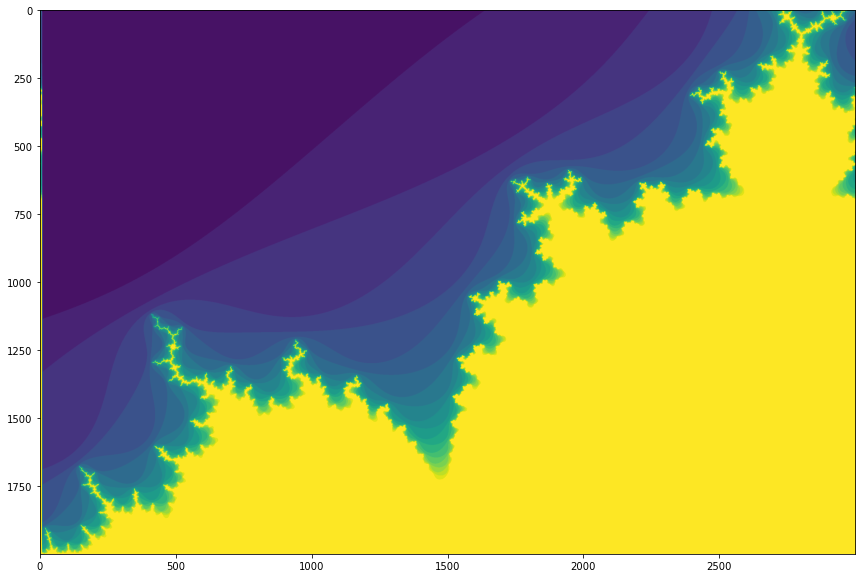

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(run_cupy_custom_kernel(2000, 3000));

In [36]:
%%timeit -o
run_cupy_custom_kernel(2000, 3000)

3.46 ms ± 8.02 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 3.46 ms ± 8.02 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [37]:
result_cupy_custom_kernel = _

## Numba-CUDA: imperative per pixel, array-oriented in the large

Numba can be compiled to CUDA, too, and it has the same interface as CuPy except that custom GPU kernels are written in a subset of Python.

One thing that's much harder in compiled Python than in CUDA C++ is to control the numeric types. To get high performance, I had to explicitly cast every part of the `z`, `c` initialization to 32-bit floats (`complex64`). It now sprawls over 6 lines, but it was necessary to get the last factor of 2×.

In [38]:
import numba.cuda

@nb.cuda.jit(fastmath=True)
def one_pixel_numba_cuda(height, width, fractal):
    x, y = nb.cuda.grid(2)                 # <--- 2-dimensional CUDA grid
    z = c = (
        np.complex64(-1.5)
        + np.complex64(y)/np.complex64(height + 1)
        - np.complex64(1j)
        + np.complex64(x)*np.complex64(1.5j)/np.complex64(width + 1)
    )
    fractal[x, y] = 20
    for i in range(20):
        z = z * z + c                      # <--- complex z**2 is much worse than z * z here
        if z.real**2 + z.imag**2 > 4:      # <--- but real-valued **2 is fine
            fractal[x, y] = i
            break

def run_numba_cuda(height, width):
    fractal = cp.empty((height, width), dtype=np.int32)
    griddim = (math.ceil(height / 32), math.ceil(width / 32))
    blockdim = (32, 32)
    one_pixel_numba_cuda[griddim, blockdim](height, width, fractal)
    return fractal.get()

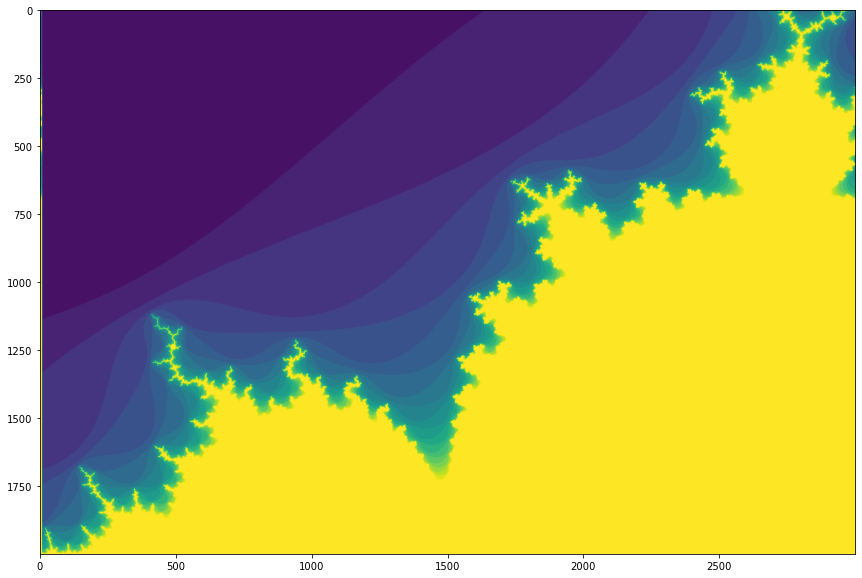

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(run_numba_cuda(2000, 3000));

In [40]:
%%timeit -o
run_numba_cuda(2000, 3000)

3.12 ms ± 87.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 3.12 ms ± 87.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [41]:
result_numba_cuda = _

## JAX: array-oriented with automatic fusion into JIT-compiled routines

JAX differs from all of the above in that it JIT-compiles array-oriented code into fused operations. It allows you to keep a fully array-oriented style but get the performance benefits of a single pass over the data.

It does this by passing a "tracer" object through your Python code, collecting a log of operations to perform, and then compiling those operations.

The benefit is that JAX's XLA compiler is exceptionally good at optimizing array-oriented code of known array dimensions. The disadvantage is that there are more constraints:

   * the tracer object can only pass through one sequence of Python code, so there can't be any `if` statements or `for` loop ranges that depend on array values (see [control flow](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#control-flow)), and
   * the data model requires all arrays to be immutable, so values can't be assigned into existing arrays (see [pure functions](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#pure-functions)).

Thus, the JAX version of the Mandelbrot calculation is very similar to the NumPy one, with `np` → `jax.numpy` and

```python
fractal[diverging_now] = i
```

replaced with

```python
fractal = jax.numpy.where(diverging_now, i, fractal)
```

Notice, though, that JAX runs at full speed even if I say things like `jax.numpy.absolute(z) > 2`. Its compiler is _smart_!

It's hard to keep JAX from using all your CPU cores, so I ran this notebook with

```bash
taskset -c 0 jupyter lab
```

to bind it to exactly one core (the one numbered `0`). The following assertion will fail and you would get misleading results if you don't run this notebook under the same conditions.

In [42]:
import jax

assert len(jax.devices("cpu")) == 1
assert len(jax.devices("gpu")) == 1

In [43]:
def run_jax_kernel(c, fractal):
    z = c
    for i in range(20):
        z = z**2 + c
        diverged = jax.numpy.absolute(z) > 2
        diverging_now = diverged & (fractal == 20)
        fractal = jax.numpy.where(diverging_now, i, fractal)    # <--- use a ternary operator ("where") instead of masked-assignment
    return fractal

run_jax_cpu_kernel = jax.jit(run_jax_kernel, backend="cpu")
run_jax_gpu_kernel = jax.jit(run_jax_kernel, backend="gpu")

def run_jax_cpu(height, width):
    y, x = jax.numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = jax.numpy.full(c.shape, 20, dtype=np.int32)
    return np.asarray(run_jax_cpu_kernel(c, fractal).block_until_ready())

def run_jax_gpu(height, width):
    y, x = jax.numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = jax.numpy.full(c.shape, 20, dtype=np.int32)
    return np.asarray(run_jax_gpu_kernel(c, fractal).block_until_ready())

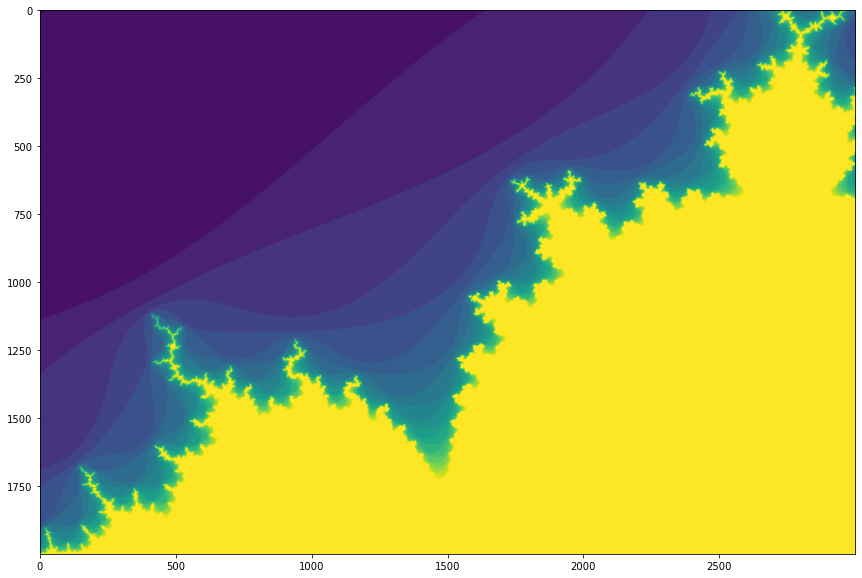

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(run_jax_cpu(2000, 3000));

In [45]:
%%timeit -o
run_jax_cpu(2000, 3000)

84.1 ms ± 969 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 84.1 ms ± 969 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [46]:
result_jax_cpu = _

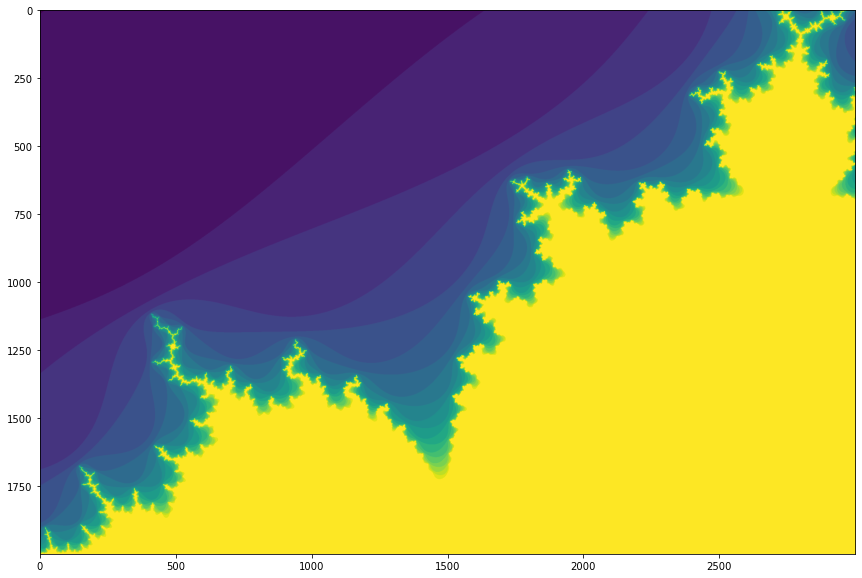

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(run_jax_gpu(2000, 3000));

In [48]:
%%timeit -o
run_jax_gpu(2000, 3000)

3.96 ms ± 74.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 3.96 ms ± 74.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [49]:
result_jax_gpu = _

## Summary

All of the results are shown in one plot below.

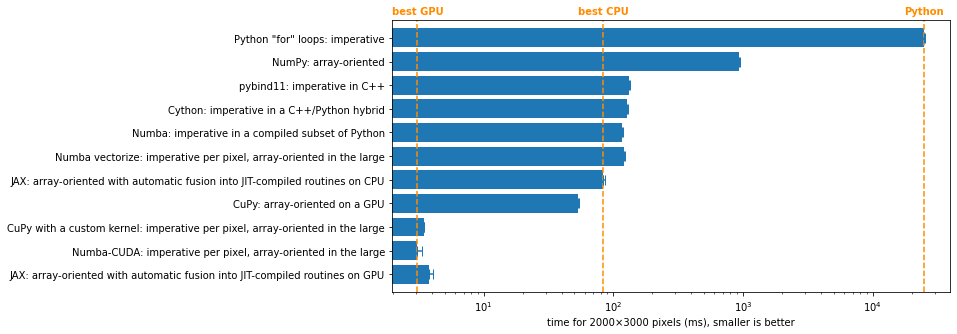

In [51]:
fig, ax = plt.subplots(figsize=(10, 5))

test_names = [
    'Python "for" loops: imperative',
    'NumPy: array-oriented',
    'pybind11: imperative in C++',
    'Cython: imperative in a C++/Python hybrid',
    'Numba: imperative in a compiled subset of Python',
    'Numba vectorize: imperative per pixel, array-oriented in the large',
    "JAX: array-oriented with automatic fusion into JIT-compiled routines on CPU",
    'CuPy: array-oriented on a GPU',
    'CuPy with a custom kernel: imperative per pixel, array-oriented in the large',
    'Numba-CUDA: imperative per pixel, array-oriented in the large',
    "JAX: array-oriented with automatic fusion into JIT-compiled routines on GPU",
][::-1]
test_results = np.array([
    1e3 * 100 * np.min(result_python.all_runs) / result_python.loops,
    1e3 * np.min(result_numpy.all_runs) / result_numpy.loops,
    1e3 * np.min(result_c_plus_plus.all_runs) / result_c_plus_plus.loops,
    1e3 * np.min(result_cython.all_runs) / result_cython.loops,
    1e3 * np.min(result_numba.all_runs) / result_numba.loops,
    1e3 * np.min(result_numba_custom_ufunc.all_runs) / result_numba_custom_ufunc.loops,
    1e3 * np.min(result_jax_cpu.all_runs) / result_jax_cpu.loops,
    1e3 * np.min(result_cupy.all_runs) / result_cupy.loops,
    1e3 * np.min(result_cupy_custom_kernel.all_runs) / result_cupy_custom_kernel.loops,
    1e3 * np.min(result_numba_cuda.all_runs) / result_numba_cuda.loops,
    1e3 * np.min(result_jax_gpu.all_runs) / result_jax_gpu.loops,
][::-1])
test_variations = np.array([
    1e3 * 100 * np.ptp(result_python.all_runs) / result_python.loops,
    1e3 * np.ptp(result_numpy.all_runs) / result_numpy.loops,
    1e3 * np.ptp(result_c_plus_plus.all_runs) / result_c_plus_plus.loops,
    1e3 * np.ptp(result_cython.all_runs) / result_cython.loops,
    1e3 * np.ptp(result_numba.all_runs) / result_numba.loops,
    1e3 * np.ptp(result_numba_custom_ufunc.all_runs) / result_numba_custom_ufunc.loops,
    1e3 * np.ptp(result_jax_cpu.all_runs) / result_jax_cpu.loops,
    1e3 * np.ptp(result_cupy.all_runs) / result_cupy.loops,
    1e3 * np.ptp(result_cupy_custom_kernel.all_runs) / result_cupy_custom_kernel.loops,
    1e3 * np.ptp(result_numba_cuda.all_runs) / result_numba_cuda.loops,
    1e3 * np.ptp(result_jax_gpu.all_runs) / result_jax_gpu.loops,
][::-1])

best_cpu = min(test_results[-3], test_results[-4], test_results[-5], test_results[-6], test_results[-7])
best_gpu = min(test_results[-9], test_results[-10], test_results[-11])

ax.axvline(test_results[-1], c="darkorange", ls="--");
ax.axvline(best_cpu, c="darkorange", ls="--");
ax.axvline(best_gpu, c="darkorange", ls="--");
ax.text(test_results[-1], len(test_results), "Python", ha="center", c="darkorange", weight="bold");
ax.text(best_cpu, len(test_results), "best CPU", ha="center", c="darkorange", weight="bold");
ax.text(best_gpu, len(test_results), "best GPU", ha="center", c="darkorange", weight="bold");
ax.barh(range(len(test_names)), test_results);
ax.errorbar(test_results + test_variations/2, range(len(test_names)), xerr=test_variations/2, capsize=5, fmt="none", c="#1f77b4");
ax.set_yticks(range(len(test_names)));
ax.set_yticklabels(test_names);
ax.set_xlabel("time for 2000×3000 pixels (ms), smaller is better");
ax.set_xscale("log");
ax.set_ylim(-0.75, len(test_results) - 0.25);
fig.savefig("mandelbrot-on-all-accelerators.svg")

The first thing to notice is the logarithmic scale: the best GPU is much better than the best CPU, which is much better than Python. In fact, it's a bigger jump (on a logarithmic scale) going from Python to compiled code than it is going from CPUs to GPUs.

Within that, many implementations huddle around the best for a given hardware. (Although JAX does something noticeably better on the CPU than all the other implementations—I don't know what it is.) The last tweaks are nowhere near as good as changing paradigm.

An array-oriented implementation with intermediate arrays, such as NumPy and CuPy without any effort to reuse memory, isn't nearly as good as fusing the operations together into a single pass. NumPy, by itself, is much better than pure Python, and if CuPy is compared with NumPy (rather than fully optimized CPU implementations), then you can get significant value from the GPU. By choosing the Mandelbrot problem, I made these two bars look worse than they would if I had chosen a problem that doesn't "iterate until converged," which requires complex bookkeeping. Also, you can do better than the above by replacing expressions like

```python
z = z**2 + c
```

with

```python
np.square(z, out=z)
np.add(z, c, out=z)
```

but if you're going to go to all that effort, obfuscating the mathematical formulas until they look like assembly code, you might as well go all the way and use a compiler to fix this problem _and_ the problem of cache coherency (single pass over data, rather than multiple).

Finally, about JAX: `@jax.jit` is a magical compiler. It was in this project that I discovered just how good it is. At first, the JAX implementation was many times faster than my best using other tools, and using JAX as a baseline, I gradually found out what was wrong with each. The fact that the JAX CPU implementation is still 40% better than pybind11, Cython, and the two Numba implementations suggests that there's still something I'm not aware of, and it's hindering these four equally.

Most importantly, the JAX implementation is an array-oriented interface. This is an interface in which you say less about how the calculation is to be performed and let the compiler handle those details for you. (And not get them wrong by 40%, as I'm apparently still doing.) That's the ultimate value of putting code in an array-oriented form. Arguably, NumPy was getting us ready for this by making array-oriented expressions the norm (for instance, in Pandas), but now JAX is actually using that form to do significant optimizations.

I'm going to be using `@jax.jit` more in the future...